## 4차 과제 - Hyperparameter Tuning을 해보자
- 주제: 하이퍼파라미터 튜닝 기법 학습
- 데이터: The History of Baseball(Pitching Data) https://www.kaggle.com/datasets/seanlahman/the-history-of-baseball?select=pitching.csv
- 사용 라이브러리: pandas, numpy, matplotlib, sklearn, imblearn, bayes_opt

### 1. EDA, 전처리

1.1 분석을 위해 사용될 라이브러리들을 import 하세요.

numpy, pandas, matplotlib, SMOTE, train_test_split, RandomForestClassifier, RandomizedSearchCV, GridSearchCV, BayesianOptimization, accuracy_score

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV

C:\Users\HamIG\AppData\Local\Temp\ipykernel_30412\737618359.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


1.2 데이터를 불러오고 info()를 통해 데이터를 살펴보세요.

In [3]:
pitching = pd.read_csv("../data/pitching.csv")
pitching.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44139 entries, 0 to 44138
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player_id  44139 non-null  object 
 1   year       44139 non-null  int64  
 2   stint      44139 non-null  int64  
 3   team_id    44139 non-null  object 
 4   league_id  44008 non-null  object 
 5   w          44139 non-null  int64  
 6   l          44139 non-null  int64  
 7   g          44139 non-null  int64  
 8   gs         44139 non-null  int64  
 9   cg         44139 non-null  int64  
 10  sho        44139 non-null  int64  
 11  sv         44139 non-null  int64  
 12  ipouts     44138 non-null  float64
 13  h          44139 non-null  int64  
 14  er         44139 non-null  int64  
 15  hr         44139 non-null  int64  
 16  bb         44139 non-null  int64  
 17  so         44139 non-null  int64  
 18  baopp      42614 non-null  float64
 19  era        44049 non-null  float64
 20  ibb   

1.3 null 값이 있는 컬럼은 모두 삭제하겠습니다(원래는 다른 처리를 해야 하지만 컬럼 수는 충분하니까..ㅎㅎ 야구 잘 몰라서 그런 거 아닙니다.).

In [4]:
pitching = pitching.dropna(axis=1)

pitching.head()

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,bechtge01,1871,1,PH1,1,2,3,3,2,0,0,43,23,0,11,1,0,42
1,brainas01,1871,1,WS3,12,15,30,30,30,0,0,361,132,4,37,13,0,292
2,fergubo01,1871,1,NY2,0,0,1,0,0,0,0,8,3,0,0,0,0,9
3,fishech01,1871,1,RC1,4,16,24,24,22,1,0,295,103,3,31,15,0,257
4,fleetfr01,1871,1,NY2,0,1,1,1,1,0,0,20,10,0,3,0,0,21


1.4 연도 별로 몇개의 데이터가 있는 지 확인 후 데이터가 얼마 없는 과거 데이터는 삭제하겠습니다. 이를 위해 연도 별 데이터 수를 계산하고 line plot으로 그리세요.

In [5]:
year_pit = pitching.groupby("year").size().reset_index(name = "counts")
year_pit

,year,counts
0,1871,19
1,1872,23
2,1873,25
3,1874,17
4,1875,47
...,...,...
140,2011,707
141,2012,722
142,2013,726
143,2014,746


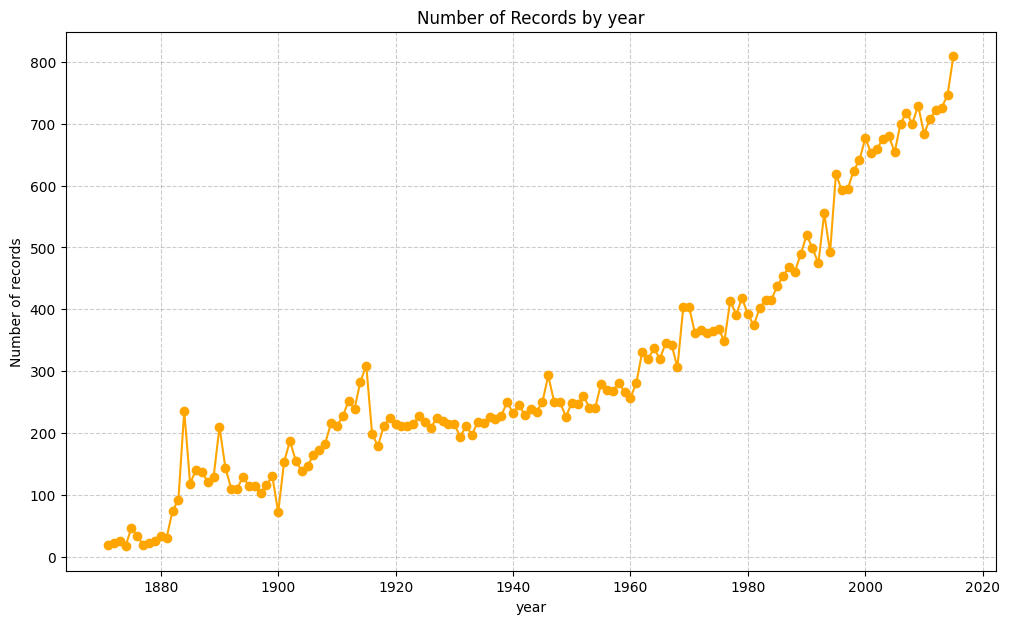

In [6]:
plt.figure(figsize=(12, 7))
plt.plot(year_pit["year"], year_pit["counts"], marker = "o", color = 'orange')

plt.xlabel('year')
plt.ylabel('Number of records')
plt.title('Number of Records by year')

plt.grid(alpha = 0.4, linestyle = '--', color = 'gray')

1.5 보다 최신 분석을 위해 1980년 이후의 데이터만 남기고 몇개의 데이터가 남았는지 확인하세요.

In [7]:
pit_1980 = pitching[pitching['year'] >= 1980]

pit_1980

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
22982,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
22983,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
22984,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
22985,allarbr01,1980,1,TEX,0,1,5,2,0,0,0,13,9,0,10,10,0,13
22986,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44134,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
44135,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
44136,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
44137,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


In [8]:
pit_1980.shape[0]

21157

1.6 reset_index()를 통해 재배열하세요.

In [9]:
pit_1980_reset = pit_1980.reset_index()

pit_1980_reset = pit_1980_reset.drop(columns=['index'])

pit_1980_reset

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
3,allarbr01,1980,1,TEX,0,1,5,2,0,0,0,13,9,0,10,10,0,13
4,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21152,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
21153,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
21154,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
21155,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.7 투수의 승리 수를 예측해보겠습니다. w 컬럼의 value를 확인해보세요.

In [10]:
pit_1980_reset['w'].value_counts()

w
0     5854
1     3197
2     2356
3     1744
4     1453
5     1114
6      878
7      730
9      560
8      557
10     450
11     434
12     384
13     317
14     287
15     242
16     193
17     125
18     102
19      61
20      53
21      32
22      17
24       8
23       7
25       1
27       1
Name: count, dtype: int64

1.8 0승 투수(출전하지 않은 경우도 존재)가 많으므로 승리 수가 0인 데이터는 삭제하겠습니다.

In [11]:
pit_1980_del = pit_1980_reset[pit_1980_reset['w'] != 0]

pit_1980_del.shape[0]

15303

1.9 Regression이 아닌 Classification으로 분석해보겠습니다. 이를 위해 10을 기준으로 w를 10승 이상이면 1, 10승 미만이면 0인 Binary 형태로 변환하세요.

In [12]:
pit_1980_del['w'] = pit_1980_del['w'].apply(lambda x: 1 if x >= 10 else 0)

pit_1980_del

C:\Users\HamIG\AppData\Local\Temp\ipykernel_30412\3540384910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pit_1980_del['w'] = pit_1980_del['w'].apply(lambda x: 1 if x >= 10 else 0)


,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,allenne01,1980,1,NYN,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,andujjo01,1980,1,HOU,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,wrighmi01,2015,1,BAL,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,wrighst01,2015,1,BOS,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,yateski01,2015,1,TBA,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,youngch03,2015,1,KCA,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.10 value_counts()를 통해 잘 나눠졌는지 확인해보세요.

In [13]:
pit_1980_del['w'].value_counts()

w
0    12589
1     2714
Name: count, dtype: int64

1.11 종속 변수의 밸런스가 맞지 않는 것으로 확인됩니다. 이를 해결하기 위해 Under Sampling 혹은 Over Sampling 기법을 사용할 수 있는데 Under Sampling의 경우 데이터가 많지 않는 상황에서 사라지는 데이터가 과도하게 많으므로 Over Sampling 기법 중 SMOTE 기법을 사용해보겠습니다. 사용하기 전에 player_id, year, team_id 컬럼은 지우고 가겠습니다.

In [14]:
pit_1980_smote = pit_1980_del.drop(columns=['player_id', 'year', 'team_id'])

pit_1980_smote

,stint,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,1,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,1,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,1,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,1,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,1,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,1,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,1,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,1,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,1,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.12 SMOTE 기법을 활용해 w의 balance를 맞추세요(sampling_strategy='auto', random_state = 123).

In [15]:
sm = SMOTE(sampling_strategy='auto', random_state = 123)


X = pit_1980_smote.drop(columns=['w'])
y = pit_1980_smote['w']  

X_resample, y_resample = sm.fit_resample(X, y)


pit_1980_re = pd.concat([pd.DataFrame(y_resample, columns=['w']),
                         pd.DataFrame(X_resample, columns=X.columns)], axis=1)

1.13 balance가 잘 맞춰졌는지 확인하세요.

In [16]:
pit_1980_resamp = pit_1980_re.reindex(columns=['w', 'l', 'g', 'gs', 'cg', 'sho', 'sv', 'h', 'er', 'hr', 'bb', 'so', 'bk', 'r', 'stint'])

In [17]:
pit_1980_resamp['w'].value_counts()

w
0    12589
1    12589
Name: count, dtype: int64

In [18]:
pit_1980_resamp

,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r,stint
0,0,13,40,21,5,1,2,193,79,13,66,74,1,83,1
1,1,12,31,31,7,2,0,228,98,27,49,78,1,110,1
2,1,11,35,35,7,1,0,227,108,20,74,114,0,120,1
3,0,10,59,0,0,0,22,87,40,7,40,79,1,43,1
4,0,8,35,14,0,0,2,132,53,8,43,75,0,59,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25173,1,14,34,34,3,0,0,267,131,24,86,139,0,142,1
25174,1,7,32,32,1,0,0,210,88,21,69,105,0,100,1
25175,1,7,29,29,4,1,0,172,68,16,52,129,1,72,1
25176,1,5,71,0,0,0,6,90,35,6,43,97,2,43,1


1.14 SMOTE의 동작 방식에 대해 작성하고 Over Sampling의 장/단점에 대해 작성하세요.

SMOTE는 데이터 수가 적은 클래스 쪽의 샘플 수를 늘리는 오버 샘플링 기법이다. \
무작위로 추출된 데이터에 대하여 k-최근접 이웃을 골라 해당 점과 이웃 점들을 선으로 잇고, 선 위에서 임의의 점을 골라 새로운 데이터로 취급한다. 


+ 장점 
    1. 단순히 데이터를 복제하는 것이 아니라, 인접한 데이터 간의 관계를 고려하여 생성하기 때문에 과적합을 방지할 수 있다.
    2. 데이터를 제거하지 않아서 데이터의 다양성과 정보를 최대한 보존할 수 있다.  
    
+ 단점  
    1. 이웃 데이터가 이상치 같은 잘못된 데이터일 경우, 노이즈가 발생할 수 있다.
    2. 작은 데이터셋의 경우, 소수 클래스 데이터 수가 매우 적기 때문에 성능 향상을 기대하기 힘들다. 

1.15 다른 Over Sampling 기법들엔 어떤 것들이 있는지 작성하세요(2개 이상).

+ RandomOverSampler : sklearn에서 제공하는 클래스로, 이미 존재하는 데이터를 무작위로 추출하여 새로운 데이터를 생성하는 것이다. 즉, 중복된 데이터를 통해서 데이터의 절대적인 양을 늘리는 것이다.

+ ADASYN(Adaptive Synthetic) : SMOTE 알고리즘은 학습이 어려운 데이터를 고려하지 못한다는 단점을 가졌는데, 이러한 단점을 보완한 알고리즘이다. 샘플링된 데이터 주변의 데이터 중에서 다른 클래스에 속하는 데이터의 수를 고려하여 데이터를 늘린다. 즉, 샘플링된 데이터 주변에 다른 클래스에 속한 데이터가 많을수록, 같은 클래스에 속한 데이터를 많이 생성하여, 클래스 간의 경계를 명확히 한다. 

### 2. 예측 및 분석

2.1 본격적으로 분석을 진행하겠습니다. 본 차시는 Hyperparameter Tuning에 대해 학습하는 것이 목적이므로 모델은 RandomForest Classifier 하나만 사용하도록 하겠습니다. 먼저 데이터를 train, validation, test 3개로 나누세요(trian-60%, val-20%, test-20%).

In [19]:
X = pit_1980_resamp.drop(columns=['w'])
y = pit_1980_resamp['w'] 

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=123) 

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=123)

In [20]:
print("Train set size : ", X_train.shape[0])
print("Validation set size : ", X_val.shape[0])
print("Test set size : ", X_test.shape[0])

Train set size :  15106
Validation set size :  5036
Test set size :  5036


2.2 train test에 validation set을 추가하는 이유가 뭔지 작성하세요.

train / test로만 분리하게 되면, train data로 만든 모델을 검증하기 위해 test data만 사용한다.\
이때, test data으로만 모델 성능을 확인하고 파라미터를 수정하면, 최종 모델은 test data에서만 성능이 좋은 모델이 될 것이다.\
즉, test data에 대해 과적합이 발생해서 다른 데이터가 들어왔을 때는 예측력이 떨어질 수 있다. 

2.3 Randomized SearchCV로 최적의 파라미터 셋을 찾으세요(성능 지표는 accuracy score).

In [20]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [21]:
rf = RandomForestClassifier()

In [22]:
# 랜덤 서치 객체 
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,  # 반복 횟수
    verbose=2,
    scoring='accuracy', 
    random_state=123
)

# 서치 수행
random_search.fit(X_train, y_train)

# test 예측
y_pred = random_search.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

# val 예측
y_pred2 = random_search.best_estimator_.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred2)
print("Val Accuracy:", val_accuracy)

# 하이퍼파라미터 출력
print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=10; total time=

Test Accuracy: 0.960087370929309\
Val Accuracy: 0.9610802223987291\
Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}

2.4 위에서 지정한 hyperparameter들이 각각 무엇을 의미하는지 작성하세요.

+ n_estimators: 모델에서 사용할 의사 결정 트리의 개수

+ max_depth: 각 의사 결정 트리의 최대 깊이. 값이 클수록 더 복잡한 모델이 된다. 

+ min_samples_split: 노드를 분할하기 위해 필요한 최소의 샘플 수

+ min_samples_leaf: 리프 노드가 가져야 하는 최소 샘플 수

+ bootstrap: 데이터의 복원 추출 여부. True로 설정하면 부트스트랩 샘플링을 사용하여 데이터셋에서 샘플을 추출합니다.

+ criterion: 노드 분할 기준.'gini'는 지니 불순도를 사용하고, 'entropy'는 엔트로피를 사용하여 불순도를 측정한다. 두 방법 모두 노드의 순도를 최대화하는 방향으로 분할한다. 

2.5 Grid SearchCV로 최적의 파라미터 셋을 찾으세요.

In [76]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [77]:
rf = RandomForestClassifier()

In [86]:
# 그리드 서치 객체 
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    verbose=2
)

# 서치 수행
grid_search.fit(X_train, y_train)

# test 예측
y_pred = grid_search.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

# val 예측
y_pred2 = grid_search.best_estimator_.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred2)
print("Val Accuracy:", val_accuracy)

# 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END bootstrap=True, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3

Test Accuracy: 0.9614773629864972\
Val Accuracy: 0.9634630659253376\
Best Hyperparameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

2.6 Randomized SearchCV와 Grid SearchCV의 차이와 장단점에 대해 설명하세요.

<figure>
    <img src="https://miro.medium.com/v2/resize:fit:781/1*8uSZqUSGa-UGF-0CDBd4Jw.png">
</figure>

+ RandomizedSearchCV
    + 장점
        1. 하이퍼파라미터 조합을 랜덤하게 선택하므로, 빠른 수렴이 가능하다. 
        2. 조합 탐색에 대한 반복 횟수를 사용자가 지정할 수 있어 탐색 시간을 관리할 수 있다. 
    + 단점:
        1. 조합이 랜덤하게 선택되서 최적의 조합을 놓칠 수 있다. 
        2. 반복 횟수가 많아야 높은 성능의 파라미터 조합을 찾을 수 있어서 탐색 시간이 오래 걸릴 때도 있다.  

----

+ GridSearchCV
    + 장점
        1. 사용자가 지정한 하이퍼파라미터 조합을 모두 탐색하기 때문에 최적의 조합을 찾을 수 있다. 
    + 단점
        1. 탐색할 하이퍼파라미터 조합 수가 많을수록 탐색 시간은 기하급수적으로 늘어난다.  

2.7 이번엔 Bayesian Optimization을 사용해 파라미터 튜닝을 진행해보겠습니다.

In [87]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [95]:
rf = RandomForestClassifier()

In [97]:
# 그리드 서치 객체 
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=param_grid,
    n_iter=50, 
    scoring='accuracy',
    verbose=2
)

# 서치 수행
bayes_search.fit(X_train, y_train)

# test 예측
y_pred = bayes_search.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

# val 예측
y_pred2 = bayes_search.best_estimator_.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred2)
print("Val Accuracy:", val_accuracy)

# 하이퍼파라미터 출력
print("Best Hyperparameters:", bayes_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=entropy, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, criterion=gini, max_depth=10, min_samples_lea

Test Accuracy: 0.9616759332803813\
Val Accuracy: 0.9634630659253376\
Best Hyperparameters: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', None), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])

2.8 진행한 튜닝 과정에서 찾은 최적의 파라미터 셋으로 다시 학습을 진행한 후 최종 accuracy score을 출력하세요.

In [98]:
random = random_search.best_estimator_
grid = grid_search.best_estimator_
bayes = bayes_search.best_estimator_

In [99]:
rf_r = RandomForestClassifier(n_estimators = 50, 
                              min_samples_split = 2, 
                              min_samples_leaf = 1, 
                              max_depth = None, 
                              criterion = 'gini', 
                              bootstrap = False)

rf_g = RandomForestClassifier(n_estimators = 200, 
                              min_samples_split = 2, 
                              min_samples_leaf = 1, 
                              max_depth = None, 
                              criterion = 'entropy', 
                              bootstrap = False)

rf_b = RandomForestClassifier(n_estimators = 200, 
                              min_samples_split = 2, 
                              min_samples_leaf = 1, 
                              max_depth = None, 
                              criterion = 'gini', 
                              bootstrap = False)

In [100]:
### random search

rf_r.fit(X_train, y_train)

y_pred_r_t = rf_r.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_r_t)
print("random search Test Accuracy:", test_accuracy)

y_pred_r_v = rf_r.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_r_v)
print("random search Val Accuracy:", val_accuracy)

random search Test Accuracy: 0.9616759332803813
random search Val Accuracy: 0.9612787926926132


In [101]:
### grid search

rf_g.fit(X_train, y_train)

y_pred_g_t = rf_g.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_r_t)
print("grid search Test Accuracy:", test_accuracy)

y_pred_g_v = rf_g.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_g_v)
print("grid search Val Accuracy:", val_accuracy)

grid search Test Accuracy: 0.9616759332803813
grid search Val Accuracy: 0.9626687847498014


In [102]:
### bayes search

rf_b.fit(X_train, y_train)

y_pred_b_t = rf_b.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_r_t)
print("bayes search Test Accuracy:", test_accuracy)

y_pred_b_v = rf_b.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_b_v)
print("bayes search Val Accuracy:", val_accuracy)

bayes search Test Accuracy: 0.9616759332803813
bayes search Val Accuracy: 0.9626687847498014


### 3. 자유분석

최적의 파라미터 셋을 찾고 성능을 높여보세요.

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    print('오차 행렬,\n', confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

In [41]:
# optuna 

import optuna
from sklearn.metrics import f1_score

def objectiveRF(trial, x_train, y_train, x_test, y_test):
    param = {
    'n_estimators' : trial.suggest_int('n_estimators', 200, 300),
    'max_depth' : trial.suggest_int('max_depth', 20, 35),
    'min_samples_split' : trial.suggest_int('min_samples_split', 2, 6),
    'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 5),
    'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy",]),
    'bootstrap' : trial.suggest_categorical('bootstrap', [True, False])
    }
    
    model = RandomForestClassifier(**param)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objectiveRF(trial, X_train, y_train, X_test, y_test), n_trials=70)

print('Best score {}, \nparameter {}'.format(study.best_trial.value, study.best_trial.params))

[I 2024-04-07 23:04:27,141] A new study created in memory with name: no-name-b00606f1-e4d3-40db-b03c-4cf9fee91ec4
[I 2024-04-07 23:04:30,080] Trial 0 finished with value: 0.9559173947577443 and parameters: {'n_estimators': 213, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False}. Best is trial 0 with value: 0.9559173947577443.
[I 2024-04-07 23:04:32,060] Trial 1 finished with value: 0.9537331215250199 and parameters: {'n_estimators': 211, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'entropy', 'bootstrap': True}. Best is trial 0 with value: 0.9559173947577443.
[I 2024-04-07 23:04:35,224] Trial 2 finished with value: 0.9549245432883241 and parameters: {'n_estimators': 247, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 4, 'criterion': 'entropy', 'bootstrap': False}. Best is trial 0 with value: 0.9559173947577443.
[I 2024-04-07 23:04:38,865] Trial 3 finished with value: 0.9616759332803813 a

Best score 0.9632644956314536, 
parameter {'n_estimators': 271, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy', 'bootstrap': False}


Best f1-score 0.9632644956314536\
parameter {'n_estimators': 271, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy', 'bootstrap': False}

In [42]:
# 모델 정의 
rf = RandomForestClassifier(
    n_estimators=271
    , max_depth=29
    , min_samples_split=2
    , min_samples_leaf=1   
    , bootstrap=False
    , criterion='entropy'
)

In [43]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=29,
                       n_estimators=271)

test dataset 평가

In [44]:
y_pred_test = rf.predict(X_test)

clf_eval(y_test, y_pred_test)

오차 행렬,
 [[2427  133]
 [  60 2416]]
정확도: 0.9617, 정밀도: 0.9478, 재현율: 0.975767, F1: 0.9616


valid dataset 평가

In [45]:
y_pred_val = rf.predict(X_val)

clf_eval(y_val, y_pred_val)

오차 행렬,
 [[2334  139]
 [  45 2518]]
정확도: 0.9635, 정밀도: 0.9477, 재현율: 0.982442, F1: 0.9648
